In [14]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input,Conv2D,BatchNormalization,Concatenate,Conv2DTranspose,MaxPooling2D,Activation,Layer,UpSampling2D
import os
from glob import glob
import sklearn
from model import *
import sklearn.model_selection
import random
import cv2



In [15]:
# Hyperparameters
IMAGE_SIZE = 256
BATCH_SIZE = 8
BUFFER_SIZE = 1000

In [65]:

def valid_extension(image_paths,mask_paths):
    # Optional: Filter valid image formats
    valid_extensions = (".png", ".jpg", ".jpeg", ".bmp", ".tiff")
    image_paths = [f for f in image_paths if f.lower().endswith(valid_extensions)]
    mask_paths = [f for f in mask_paths if f.lower().endswith(valid_extensions)]


def load_dataset(train_path,val_path,split=0.5):
    train_x = sorted(tf.io.gfile.glob(os.path.join(train_path, "image", "*.*")))  # Matches all files
    train_y = sorted(tf.io.gfile.glob(os.path.join(train_path, "masks", "*.*")))


    images= sorted(tf.io.gfile.glob(os.path.join(val_path, "image", "*.*")))  # Matches all files
    masks = sorted(tf.io.gfile.glob(os.path.join(val_path, "masks", "*.*")))

    split_size=int(len(images)*split)
    val_x,test_x=sklearn.model_selection.train_test_split(images,test_size=split_size,random_state=42)
    val_y,test_y=sklearn.model_selection.train_test_split(masks,test_size=split_size,random_state=42) 

    # train_x,val_x=sklearn.model_selection.train_test_split(images,test_size=split_size,random_state=42)
    # train_y,val_y=sklearn.model_selection.train_test_split(masks,test_size=split_size,random_state=42)


    # train_x,test_x=sklearn.model_selection.train_test_split(train_x,test_size=split_size,random_state=42)
    # train_y,test_y=sklearn.model_selection.train_test_split(train_y,test_size=split_size,random_state=42)

    valid_extension(train_x,train_y)
    valid_extension(val_x,val_y)
    valid_extension(test_x,test_y)
    print(f"train:{len(train_x)}||val:{len(val_x)}||test:{len(test_x)}")

    return (train_x,train_y),(val_x,val_y),(test_x,test_y)

In [17]:
def decode_image(image_path, mask=False):
    """ Read and preprocess images/masks """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3 if not mask else 1)  # RGB for images, grayscale for masks
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))  # Resize
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    return image

def normalize(input_image, input_mask):
    """ Normalize input (scaling & label adjustment) """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = input_mask - 1  # Convert to zero-based indexing (assuming categorical labels)
    return input_image, input_mask

In [18]:
def load_train_images(image_path, mask_path):
    """ Load, resize, augment, and normalize training images """
    input_image = decode_image(image_path)
    input_mask = decode_image(mask_path, mask=True)

    # Data Augmentation
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_up_down(input_image)
        input_mask = tf.image.flip_up_down(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_test_images(image_path, mask_path):
    """ Load, resize, and normalize test images """
    input_image = decode_image(image_path)
    input_mask = decode_image(mask_path, mask=True)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [19]:

def tf_dataset(image_paths, mask_paths, batch_size, train=True):
    """ Create TensorFlow dataset pipeline """
    ds = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    
    if train:
        ds = ds.map(load_train_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.cache().shuffle(BUFFER_SIZE).batch(batch_size).repeat()
    else:
        ds = ds.map(load_test_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.batch(batch_size)
    
    return ds.prefetch(tf.data.experimental.AUTOTUNE)


In [20]:
import matplotlib.pyplot as plt
def display_sample(image_list):
    plt.figure(figsize=(10,10))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(image_list[i]))
        plt.axis('off')

    plt.show()

In [66]:
train_path= r"/home/manik/research/casia_dataset/train" # Update with the correct path
val_path=r"/home/manik/research/casia_dataset/val"
(train_x, train_y), (val_x,val_y),(test_x, test_y) = load_dataset(train_path,val_path)

# Create TensorFlow datasets
train_dataset = tf_dataset(train_x, train_y, BATCH_SIZE, train=True)
test_dataset = tf_dataset(test_x, test_y, BATCH_SIZE, train=False)

train:1000000||val:2500||test:2500


2025-02-09 00:21:54.838504: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


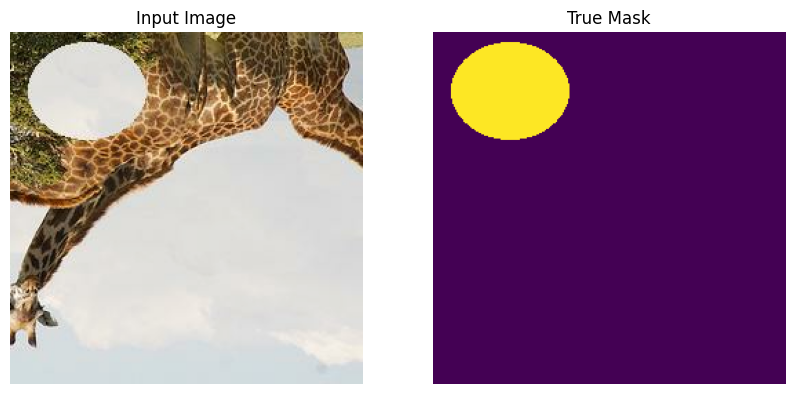

In [71]:
for images, masks in train_dataset.take(1):
    sample_image, sample_mask = images[0], masks[0]
    display_sample([sample_image, sample_mask])

In [74]:
for img_batch, mask_batch in train_dataset.take(1):  
    print("Batch Image Shape:", img_batch.shape)
    print("Batch Mask Shape:", mask_batch.shape)


Batch Image Shape: (8, 256, 256, 3)
Batch Mask Shape: (8, 256, 256, 1)


2025-02-09 00:24:40.017556: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
